In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns  # >= 0.9
import sqlite3
sns.set(context='talk', style='whitegrid', color_codes=True)

In [2]:
mpl.rcParams['figure.figsize'] = (10,6)
mpl.rcParams['legend.fontsize'] = 18

# Preamble



Type Ia supernovae (SNe Ia) are generally thought to be the thermonuclear disruption of a carbon-oxygen white-dwarf star (WD) in a binary system (see, e.g., Hillebrandt & Niemeyer 2000 for a review), but their formation scenarios and exact progenitor systems are still ambiguous. The photospheric velocity of SNe Ia measured from the strong Si II λ6355 absorption line in their spectrum (e.g., Silverman et al. 2012) at the time of peak brightness is an important parameter for studying the various properties of SNe Ia. The ejecta velocity distribution is also a possible clue for revealing asymmetries in SN Ia explosions. Recent studies reveal that the distribution of SN Ia velocity does not originate from a uniform class. [Wang, X. et al. (2013)](https://arxiv.org/abs/1303.2601) and [Zheng et al. (2018)](https://arxiv.org/abs/1712.01495) show that there exists a subclass of SNe Ia with high velocities (Figures 1 and 2), indicating a different origin for some SNe Ia.

Asymmetric SN Ia explosions could cause different measured ejecta velocities observed from different lines of sight. We intend to model the ejecta velocity of SNe Ia seen from different lines of sight through numerical simulations to test if the simulated velocity distribution could match the observed velocity distribution. We expect the model to demonstrate properties of velocity, ejecta size, and rarity of the high-velocity ejecta compared to the low-velocity. The results of the simulations will be a random sample of the velocity distribution to be compared with the real data.

Due to the limited time alloted for this project, a few descoping option was used. The original method of parameter estimation was MCMC which the posterior of the parameters were difficult to interpret. Further convergence test was needed therefore I decided MCMC was too time consuming. Parameter estimation was descoped form MCMC to grid search which provides a single set of best estimated parameters instead of a posterior. A quality slice in Si II velocity was also made to descope so that the methods matches those in Wang, X. et al. (2013) easily. Finally, the last descope made as assuming that all SNe Ia have high-velocity ejecta instead of using a prior.


# The Data

The dataset comes from the kaepora database ([Siebert, M. R. et al. 2019](https://academic.oup.com/mnras/article/486/4/5785/5484870))

In [3]:
from dataloader import import_kaepora

sn_data = import_kaepora()
sn_data.head()

,v_siII,v_siII_err
kaepora,,
2006td,10812.60,300.000
1996z,12142.10,233.568
1996x,11173.10,222.453
1996c,10689.10,222.453
2005m,8093.94,231.052


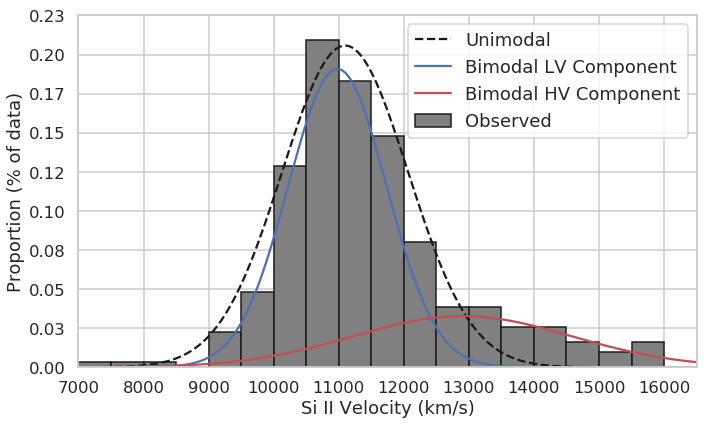

In [4]:
from scipy.optimize import curve_fit
from models import *

x = sn_data['v_siII']
bins = np.arange(7000, 17000, 500)
plt.hist(x, density=True, bins=bins, color='gray', fill=True, edgecolor='k', joinstyle='miter', label='Observed')

# Unimodal Gaussian
xrange = np.linspace(bins.min(), bins.max(), 200)
ydata, xdata = np.histogram(x, bins=bins, density=True)
xdata = (xdata[:-1] + xdata[1:]) / 2
opt, cov = curve_fit(gaussian, xdata, ydata, p0=[np.mean(x), np.std(x)])
np.savetxt('unimodal_params.csv', opt, delimiter=',')
plt.plot(xrange, gaussian(xrange, *opt), '--', color='k', label='Unimodal')

# Bimodal Gaussian
opt, cov = curve_fit(bimodal_gaussian, xdata, ydata, p0=[11000., np.std(x)/2, 15000., np.std(x)*2, 0.5])
np.savetxt('bimodal_params.csv', opt, delimiter=',')
# plt.plot(xrange, bimodal_gaussian(xrange, *opt), color='gray', label='Bimodal')
plt.plot(xrange, opt[4]*gaussian(xrange, *opt[0:2]), 'b', label='Bimodal LV Component')
plt.plot(xrange, (1-opt[4])*gaussian(xrange, *opt[2:4]), 'r', label='Bimodal HV Component')

# Plot config
plt.xticks(bins[::2], [f'{tick:.0f}' for tick in bins[::2]])
plt.xlim(bins.min(), bins.max())
plt.yticks(plt.yticks()[0], [f'{tick:.2f}' for tick in plt.yticks()[0]*500])
plt.legend(loc='upper right')
plt.xlabel('Si II Velocity (km/s)')
plt.ylabel('Proportion (% of data)')

# Save results
plt.tight_layout()
plt.savefig('velocity_dist.png', orientation='landscape', format='png', dpi=600)

## Bimodal Justification

In [22]:
unimodal_params = np.loadtxt('unimodal_params.csv', delimiter='csv')
bimodal_params = np.loadtxt('bimodal_params.csv', delimiter='csv')

def lnlike(params, x):
    """Returns the negative log likelihood of multimodal gaussian"""
    if len(params) == 2:
        ps = np.log(gaussian(x, *params))
    elif len(params) == 5:
        ps = np.log(bimodal_gaussian(x, *params))
    else:
        raise NotImplementedError()
    
    return np.sum(ps)

blnl, slnl = lnlike(bimodal_params, sn_data['v_siII']), lnlike(unimodal_params, sn_data['v_siII'])
pd.DataFrame(
    [
        [blnl, slnl],
        [np.exp(blnl), np.exp(slnl)]
    ],
    index=['log likelihood', 'likelihood']
).T

,log likelihood,likelihood
0,-2650.402651,0.0
1,-2748.058552,0.0


In [24]:
np.exp(-2650+2748)

3.637970947608805e+42

# Method

Assumptions:
    
* Velocity of the Si II in the photosphere is egg shaped inspired by the result of [Kasen and Plewa 2007](https://ui.adsabs.harvard.edu/abs/2007ApJ...662..459K/abstract) with three velocities located at three different angular position of interest:

    $$
    v_\mathrm{H} = v(\theta=0)\\
    v_\mathrm{L} = v(\theta=\pi/2)\\
    v_\mathrm{M} = v(\theta=\pi)\\
    v_H > v_M > v_L
    $$
    
* Axis of symmetry intersecting $\theta=0$ and $\theta=\pi$
* Velocity as a function of viewing angle $\theta$ is given by:

    $$
    v(\theta) = 
    \begin{cases}
    v_L - \left(\frac{v_H - v_L}{\pi/2}\right)\left(\theta - \frac{\pi}{2} \right) & 0 \le \theta \le \frac{\pi}{2}\\
    v_L + \left(\frac{v_M - v_L}{\pi/2}\right)\left(\theta - \frac{\pi}{2} \right) & \pi/2 \le \theta \le \pi
    \end{cases}
    $$
    
    The mirror opposite is true for $-\pi \le  \theta \le 0$
    
* We consider two parameters $v_H - v_L$ from here on denoted as the range of the velocity $\Delta v$ and the ratio of the velocity differences $R$:

$$
R = \frac{v_H - v_L}{v_M-v_L} = \text{const}\\
R > 1
$$

* From the SNe Ia data, $v_L$ will be sampled from the low velocity Gaussian distribution.

## Parameter Estimation - Grid Search

Using the simulation above, the best estimated parameters is determined by a grid search amongst all two parameters. The range of the grid is given below. The interval syntax is range(low, high, step):

$$
\begin{align}
\Delta v &\in \text{range}(10,~ 40,~ 10) \quad [10^3~\text{km/s}]\\
R  &\in \text{range}(4/3,~ 9/3,~ 1/3)\\
\end{align}
$$

In total, $N$ sets of parameters were simulated. Each simulation was scored by the Kolmogorov-Smirov (KS) test.

In [40]:
import pickle as pkl

with open('scores.pkl', 'rb') as f:
    scores = pkl.load(f)

pvalues = scores['pvalue']
sort_idx = np.argsort(pvalues)[::-1]

pvalues = pvalues[sort_idx]
ks = scores['ks'][sort_idx]
params = scores['params']
v_sim = scores['v_sim']

df = pd.DataFrame([
         ks,
         pvalues
     ], index=['ks', 'pvalues']).T

df['theta'] = [param['theta'] for param in params]
df['delta_v'] = [param['delta_v'] for param in params]
df.head()

,ks,pvalues,theta,delta_v
0,0.036521,0.809015,50,2500
1,0.039651,0.721789,25,3000
2,0.039751,0.718890,20,3000
3,0.050350,0.419784,30,3000
4,0.053886,0.336589,30,3500


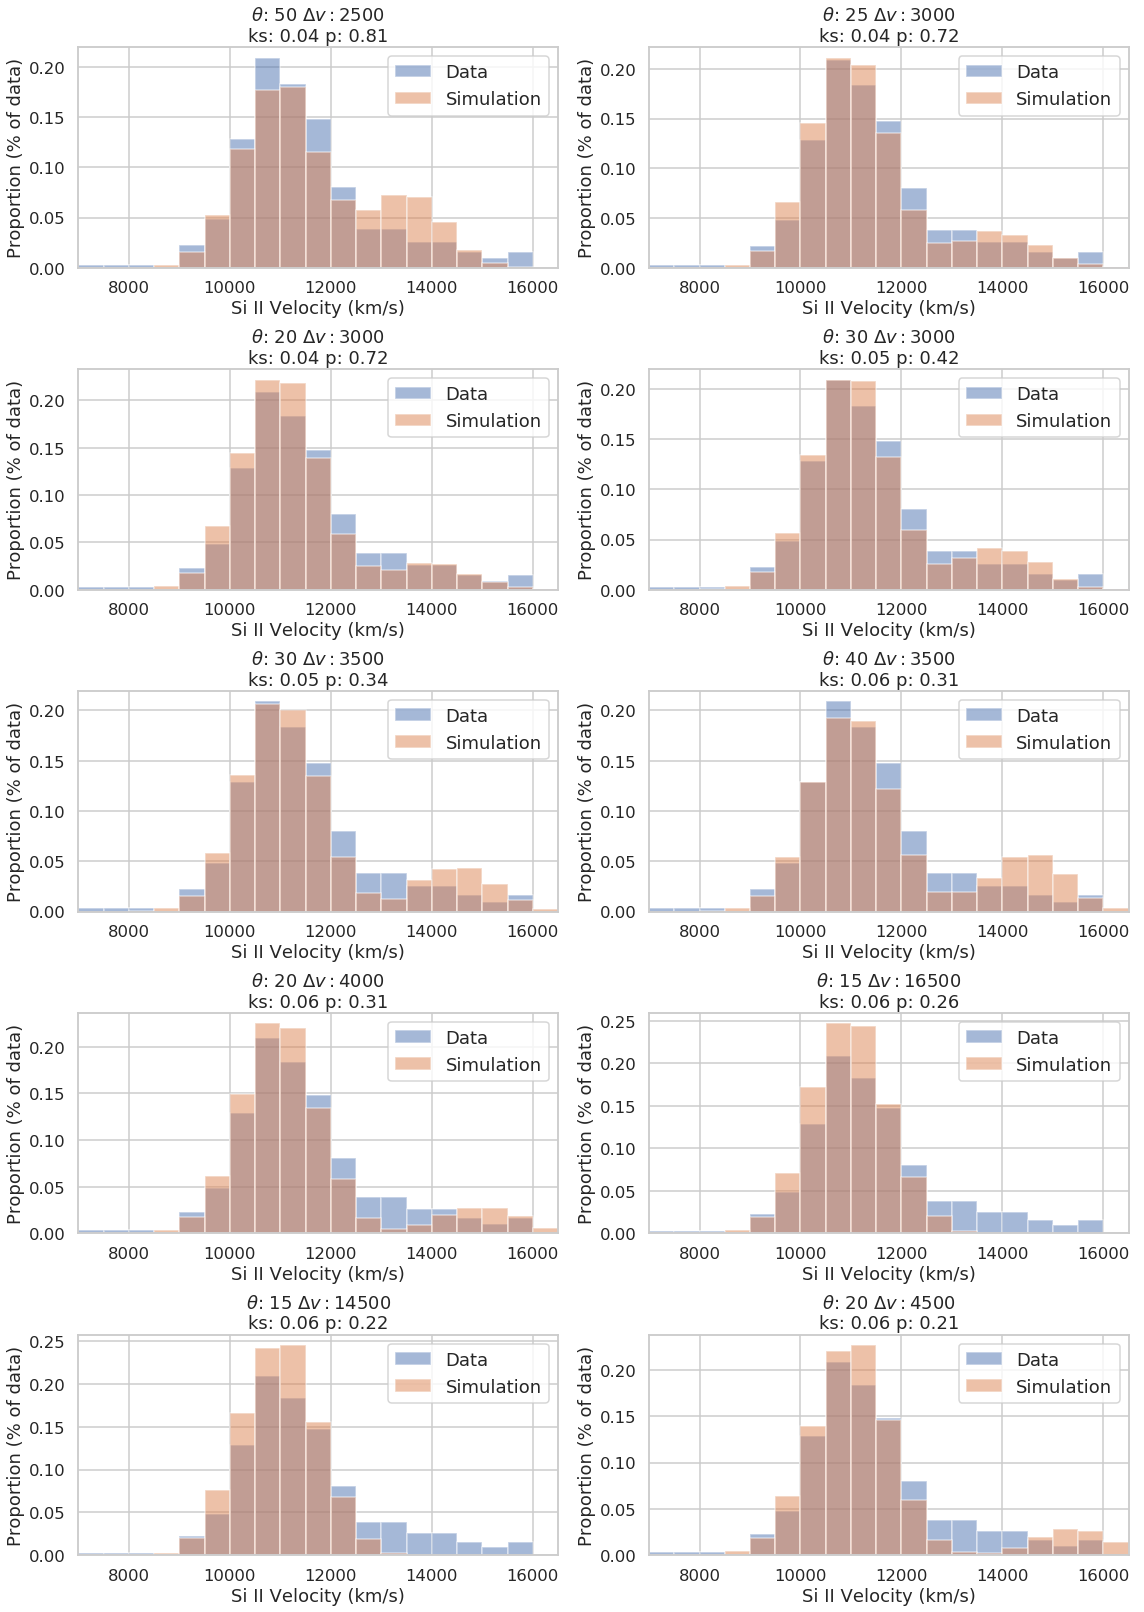

In [72]:
from scipy.stats import kstest, norm, ks_2samp

nrows, ncols = 5, 2
fig, axs = plt.subplots(nrows, ncols, figsize=(16, 4.5*nrows))


for i in range(nrows*ncols):
    ax = axs[i//ncols, i%ncols]
    bins = np.arange(7000, 17000, 500)
    xrange = np.linspace(bins.min(), bins.max(), 200)
    param = params[i]
    
#     bimodal_params = np.loadtxt('bimodal_params.csv', delimiter=',')
#     lv_params = bimodal_params[:2]
#     hv_params = bimodal_params[2:-1]
#     mixing_param = bimodal_params[-1]
#     param = params[i]
    
    
    # Data
    ax.hist(sn_data['v_siII'], bins, density=True, alpha=0.5, label='Data')
    
    # LV Component
    
    # HV Component Data Fit
#     ax.plot(xrange, gaussian(xrange, *hv_params) * (1-mixing_param), '--b', label="Data HV Fit")
    
    # HV Simulation
    # Use HV from simulation and LV from sampling data fit
#     hv_samp = hvs[i]
    
    ax.hist(v_sim[i], bins, density=True, alpha=0.5, label="Simulation")
    
    # HV Component Simulation Fit
    # Gaussian fit on the simulation
#     ydata, xdata = np.histogram(hv_samp, bins=np.arange(0.8, 1.75, 0.1) * 10, density=True)
#     xdata = (xdata[:-1] + xdata[1:]) / 2
#     opt, cov = curve_fit(gaussian, xdata, ydata, p0=[np.mean(hv_samp), np.std(hv_samp)])
#     ax.plot(xrange, gaussian(xrange, *opt) * (1-mixing_param), '--r', label="Simulation HV Fit")

    
    # Plot config
    ax.set_title(f"$\\theta$: {param['theta']} $\Delta v: ${param['delta_v']}\nks: {ks[i]:.2f} p: {pvalues[i]:.2f}")
    ax.set_xlim(bins.min(), bins.max())
    ax.set_yticklabels([f'{tick:.2f}' for tick in ax.get_yticks()*500])
    ax.set_xlabel('Si II Velocity (km/s)')
    ax.set_ylabel('Proportion (% of data)')
    ax.legend(loc='upper right')
    
plt.tight_layout()
plt.savefig('grid_search_results.png', dpi=300, format='png')

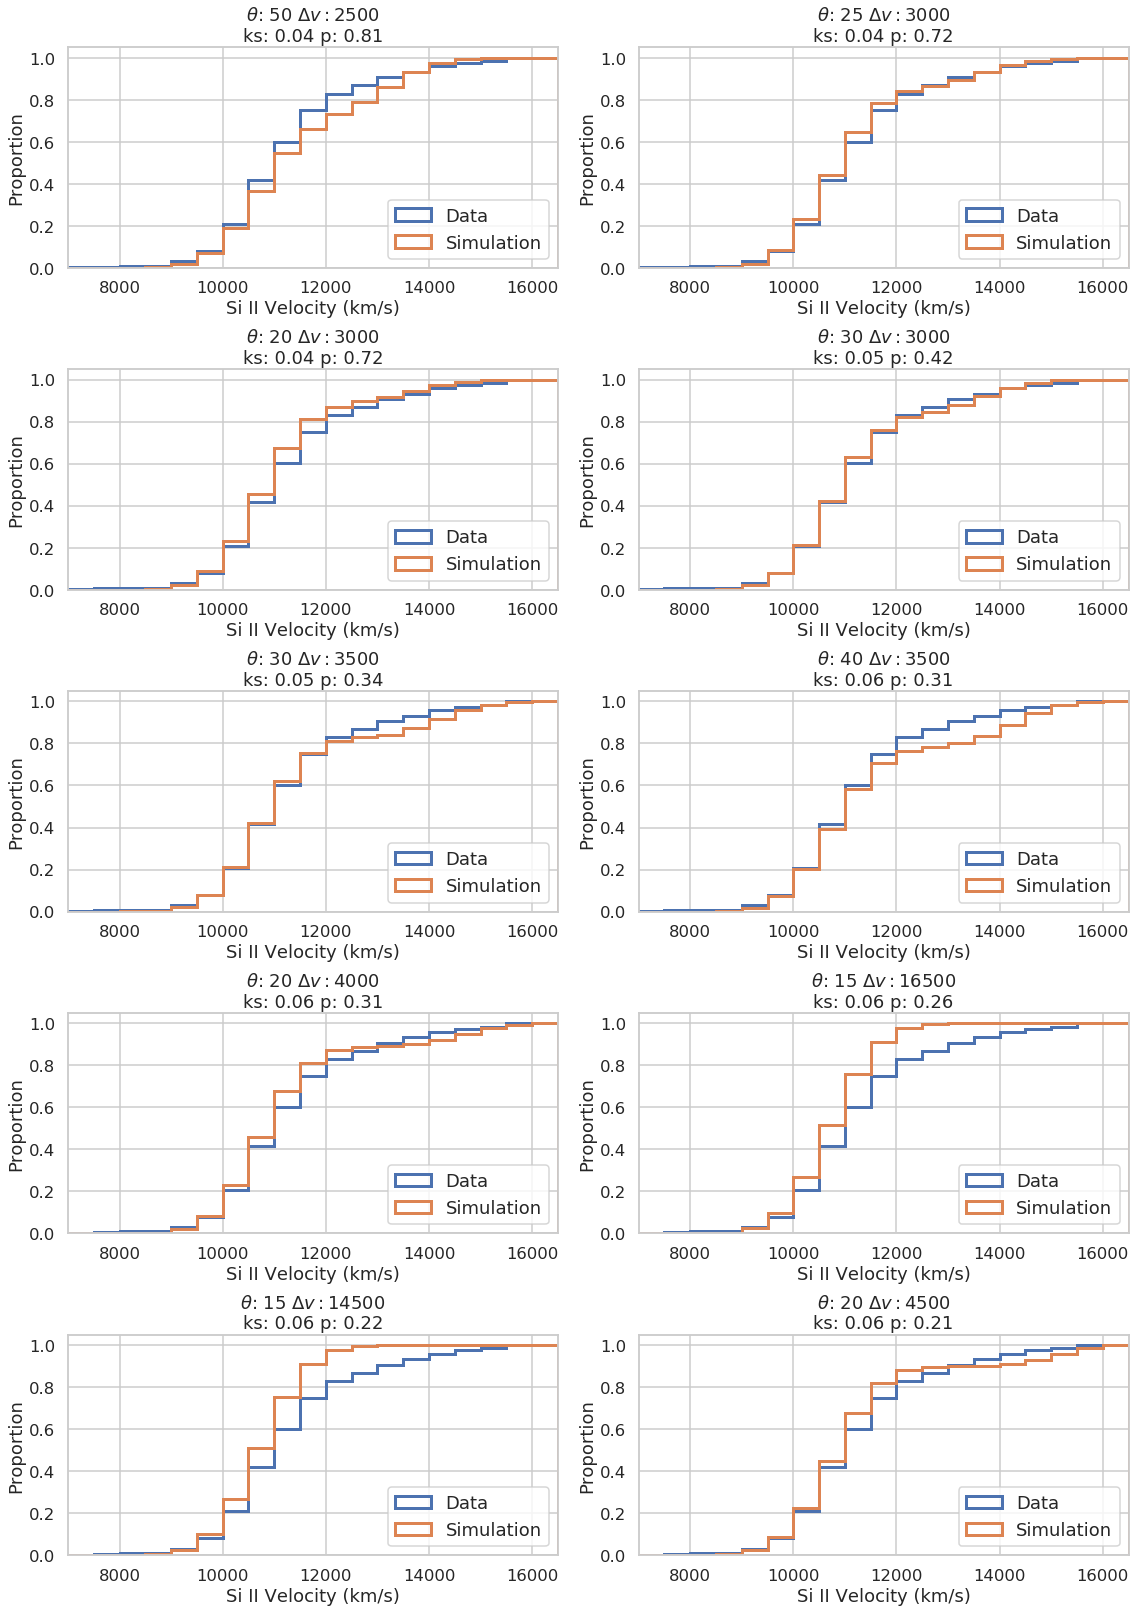

In [71]:
nrows, ncols = 5, 2
fig, axs = plt.subplots(nrows, ncols, figsize=(16, 4.5*nrows))

for i in range(nrows*ncols):
    ax = axs[i//ncols, i%ncols]
    bins = np.arange(7000, 17000, 500)
    xrange = np.linspace(bins.min(), bins.max(), 200)
    
    param=params[i]
    
    # Data
    ax.hist(sn_data['v_siII'], bins, cumulative=True, histtype='step', 
            density=True, linewidth=3, label='Data')
    
    ax.hist(v_sim[i], bins, cumulative=True, histtype='step', 
            density=True, linewidth=3, label="Simulation")
    
    # Plot config
    ax.set_title(f"$\\theta$: {param['theta']} $\Delta v: ${param['delta_v']}\nks: {ks[i]:.2f} p: {pvalues[i]:.2f}")
    ax.set_xlim(bins.min(), bins.max())
    ax.set_xlabel('Si II Velocity (km/s)')
    ax.set_ylabel('Proportion')
    ax.legend(loc='lower right')
    
plt.tight_layout()
plt.savefig('grid_search_cumulative_results.png', dpi=300, format='png')

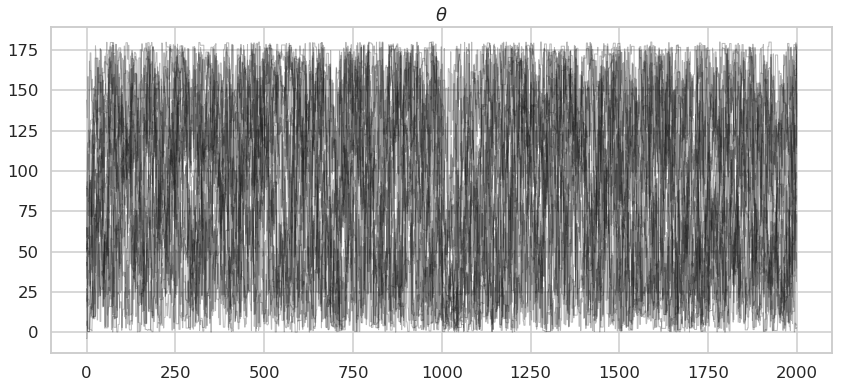

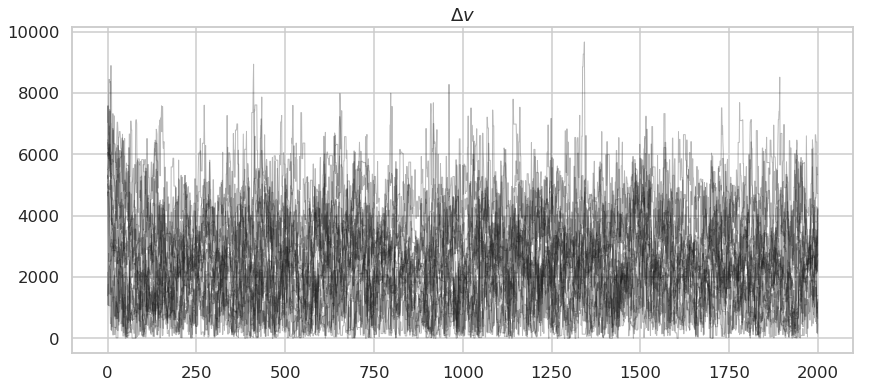

In [17]:
samples = np.load('chain.npy')
labels = [r'$\theta$', r'$\Delta v$']
for i in range(samples.shape[2]):
    plt.figure(figsize=(14,6))
    for j in range(samples.shape[0]):
        plt.plot(range(samples.shape[1]), samples[j,:,i], color='k', lw=1, alpha=0.3)
    plt.title(labels[i])

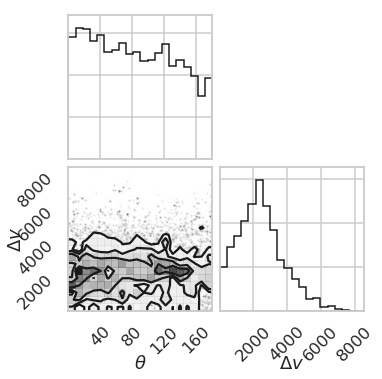

In [18]:
from corner import corner

burn_in = 1500
samples = np.load('chain.npy')
samples = samples[:, burn_in:, :].reshape((-1, samples.shape[2]))
fig = corner(samples[:,:2], labels=[r"$\theta$", r"$\Delta v$"])

# Results

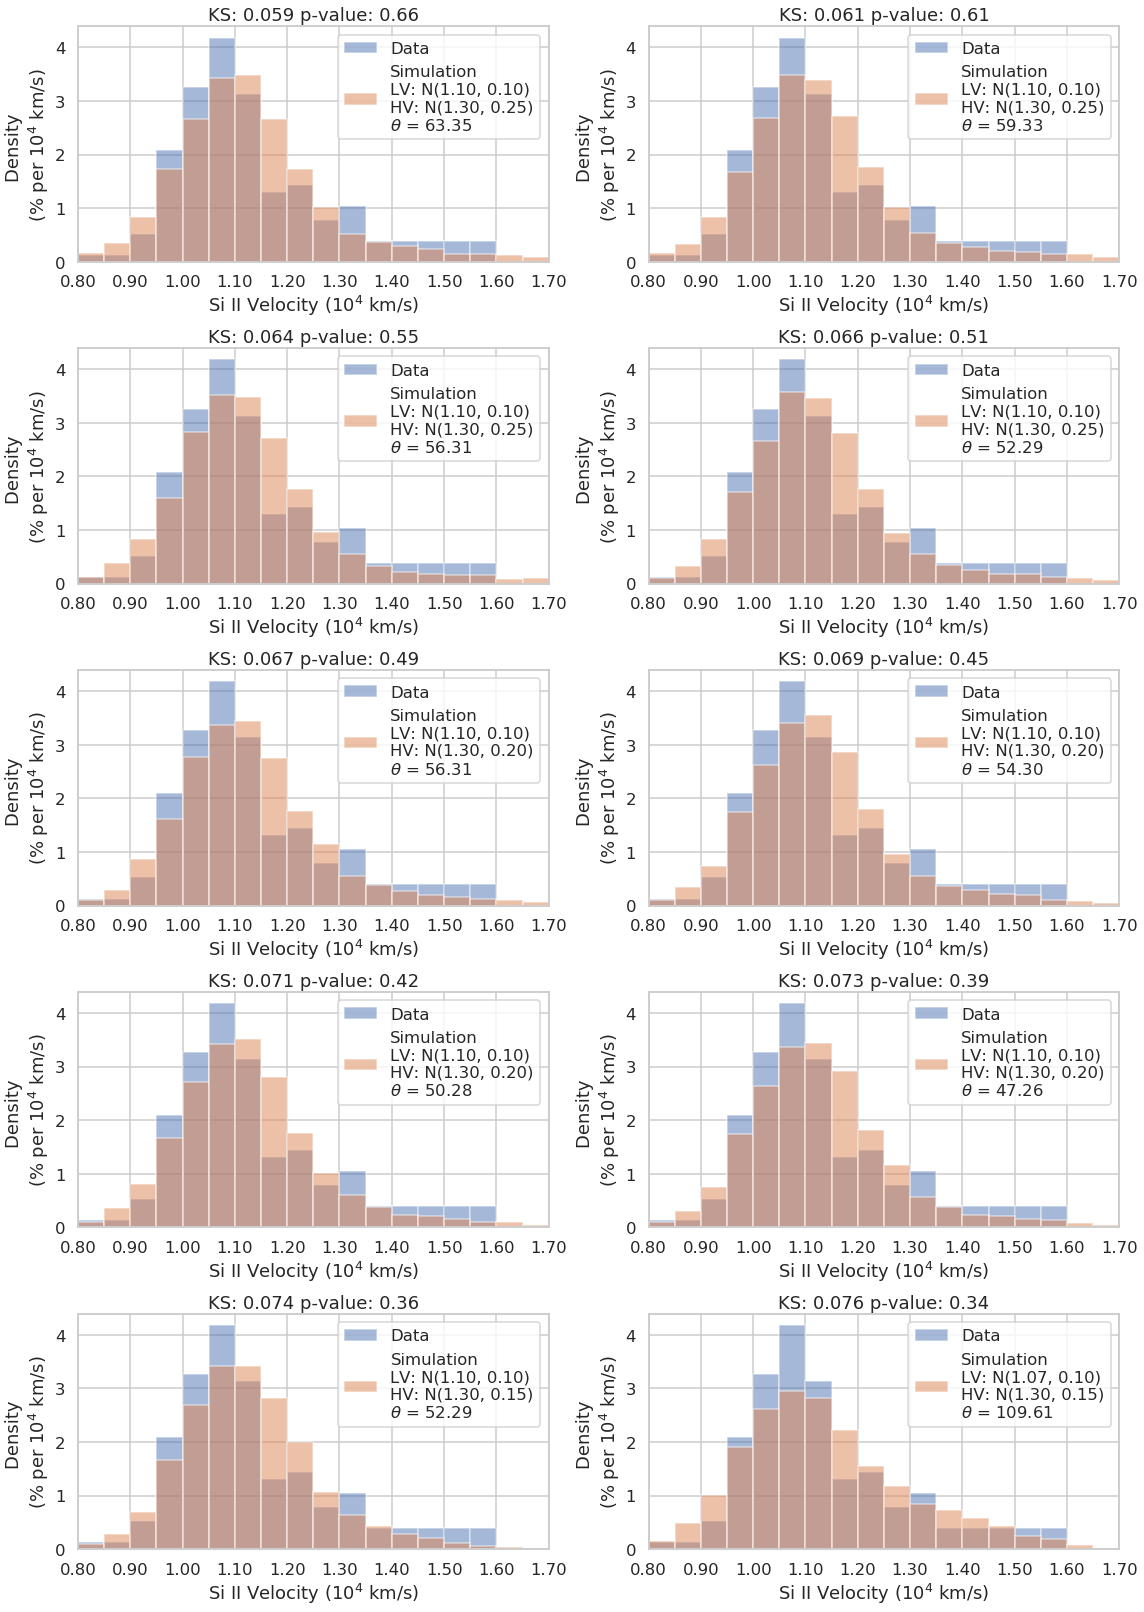

In [25]:
import pickle as pkl

with open('scores.pkl.bak', 'rb') as f:
    scores = pkl.load(f)

sort_idx = np.argsort(scores['ks'])
ks = scores['ks'][sort_idx]
pvalue = scores['pvalue'][sort_idx]
vs = scores['vs'][sort_idx]
params = scores['params'][sort_idx]

nrows, ncols = 5, 2
fig, axs = plt.subplots(nrows, ncols, figsize=(16, 4.5*nrows))

for i in range(nrows*ncols):
    best_vs = vs[i]
    best_ks = ks[i]
    best_pvalue = pvalue[i]
    best_params = params[i]
    mu_LV, sigma_LV = best_params['mu_LV'], best_params['sigma_LV']
    mu_HV, sigma_HV = best_params['mu_HV'], best_params['sigma_HV']
    theta = best_params['theta']
    
    ax = axs[i//ncols, i%ncols]
    bins = np.arange(0.8, 1.75, 0.05)
    ax.hist(sn_data['v_siII'], bins, density=True, alpha=0.5, label='Data')
    ax.hist(best_vs, bins, density=True, alpha=0.5, 
            label=(
                f'Simulation\n' + 
                f'LV: N({mu_LV:.2f}, {sigma_LV:.2f})\n' + 
                f'HV: N({mu_HV:.2f}, {sigma_HV:.2f})\n' + 
                fr'$\theta$ = {theta:.2f}'
            )
           )
    ax.set_xlabel('Si II Velocity ($10^3$ km/s)')
    ax.set_ylabel('Density \n(% per $10^3$ km/s)')
    ax.set_title(f"KS: {best_ks:.3f} p-value: {best_pvalue:.2f}")
    ax.set_xticks(bins[::2])
    ax.set_xticklabels([f'{tick:.2f}' for tick in bins[::2]])
    ax.set_xlim(bins.min(), bins.max())
    ax.legend()
plt.tight_layout()

Plotted above is the velocity distribution of the top 10 KS scoring parameters. Notice all the parameters for the first 9 simulations are similar with varying spread $\theta$ ranging from about [45, 65] degrees. The last simulation plotted however greatly differs in $\theta$. This suggest a possible degeneracy in the best estimated $\theta$ parameter. 

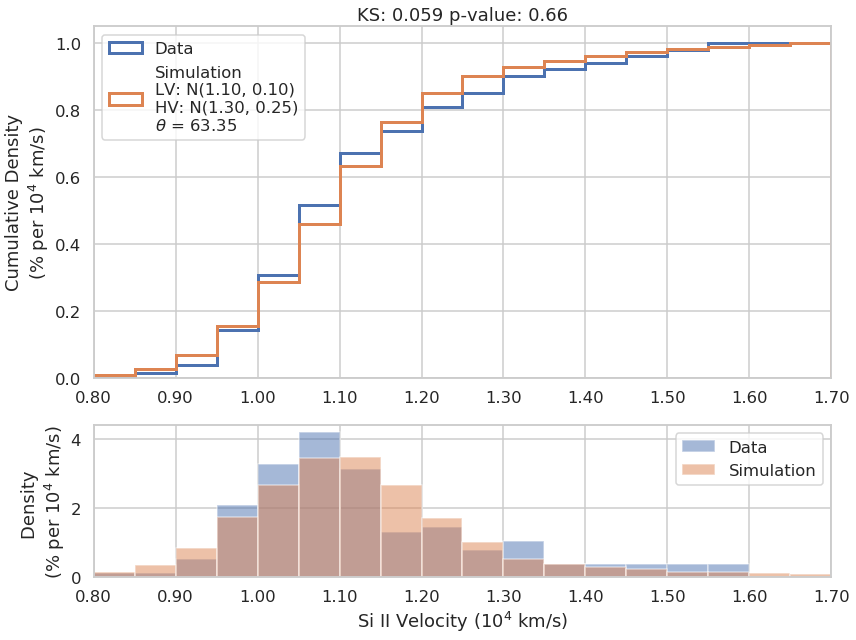

In [26]:
i = 0
best_vs = vs[i]
best_ks = ks[i]
best_pvalue = pvalue[i]
best_params = params[i]
mu_LV, sigma_LV = best_params['mu_LV'], best_params['sigma_LV']
mu_HV, sigma_HV = best_params['mu_HV'], best_params['sigma_HV']
theta = best_params['theta']

plt.figure(figsize=(12, 9))
ax2 = plt.subplot2grid((3,1), (2,0))
ax1 = plt.subplot2grid((3,1), (0,0), rowspan=2, sharex=ax2)

bins = np.arange(0.8, 1.75, 0.05)
ax2.hist(sn_data['v_siII'], bins, density=True,
         alpha=0.5, label='Data')
ax2.hist(best_vs, bins, density=True, 
         alpha=0.5, label=f'Simulation')
ax2.set_xlabel('Si II Velocity ($10^3$ km/s)')
ax2.set_ylabel('Density \n(% per $10^3$ km/s)')


ax1.hist(sn_data['v_siII'], bins, cumulative=True, histtype='step', 
        density=True, linewidth=3, label='Data')
ax1.hist(best_vs, bins, cumulative=True, histtype='step', 
        density=True, linewidth=3, label=(
            f'Simulation\n' + 
            f'LV: N({mu_LV:.2f}, {sigma_LV:.2f})\n' + 
            f'HV: N({mu_HV:.2f}, {sigma_HV:.2f})\n' + 
            fr'$\theta$ = {theta:.2f}'))
ax1.set_ylabel('Cumulative Density\n(% per $10^3$ km/s)')
ax1.set_title(f'KS: {best_ks:.3f} p-value: {best_pvalue:.2f}')

# Plot config
ax1.legend(loc='upper left')

ax2.set_xticks(bins[::2])
ax2.set_xticklabels([f'{tick:.2f}' for tick in bins[::2]])
ax2.set_xlim(bins.min(), bins.max())
ax2.legend()

plt.tight_layout()
plt.savefig('best.png', dpi=300, format='png')

Plotted above is the top KS scoring simulation. The bottom plot is the same plot as the previous figure. The top plot is the cumulative distirbution of the bottom.

# Discussion

The distinction in Si II velocity distribution may be described by asymmetries in SNe Ia's ejecta. We produced a two-dimensional simulation under the assumption that the ejecta asymmetries is only angular (i.e., the ejecta is anisotropic) where the there exist a angular region on the photospheric shell that has a velocity higher than the remaining shell. These two region are labeled as high-velocity ejecta (HV) and low-velocity ejecta (LV). We assume for a given SN Ia, its ejecta velocity of the HV and LV region are of a single value sampled from two normal distributions. The best performing simulations resulted in reasonable and consistent values of the normal distribution's mean and standard deviatons. However, the parameter describing the angular spread of the HV ejecta region varies a lot. Further constraints are required to gather any intuitive conclusion to whether or not the simulation does represent the data. These constraints should come from empirical evidence and existing SNe Ia models.

# References

Hillebrandt, W., & Niemeyer, J. C. 2000, ARA&A, 38, 191

Levanon, N., & Soker, N. 2019, arXiv:1901.05057

Polin, A., Nugent, P. E., & Kasen, D. 2019, ApJ, 873, 1

Silverman, J. M., Kong, J. J., Filippenko, A. V., et al., 2012, MNRAS, 425, 1819

Wang, X., Wang, L., & Filippenko, A. V.  2013, Science, 340, 6129

Zheng, W., Kelly, P. L., & Filippenko, A. V. 2018, ApJ, 858, 104

# Appendix

## Grid Search

```python
import time
import numpy as np
import pickle as pkl
from scipy.stats import norm, ks_2samp
from sklearn.model_selection import ParameterGrid
from dataloader import import_sn_data

param_grid = {
    'theta': np.linspace(0, 180, 180),
    'mu_HV': np.linspace(1.3, 5, 10),
    'sigma_HV': np.linspace(0.1, 0.3, 5),
    'mu_LV': np.linspace(1., 1.3, 10),
    'sigma_LV': np.linspace(0.1, 0.5, 5),
}

def model_vdist(theta, mu_HV, sigma_HV, mu_LV, sigma_LV, sample_size=1000):
    los = np.random.uniform(-180, 180, sample_size)

    cond = (los > -theta/2) & (los < theta/2)
    hv_size = np.sum(cond)
    lv_size = np.sum(~cond)

    vs = np.append(
        np.random.normal(mu_HV, sigma_HV, hv_size),
        np.random.normal(mu_LV, sigma_LV, lv_size)
    )
    return vs


def simulate_grid(vs_data, param_grid, **kwargs):
    param_grid = ParameterGrid(param_grid)
    scores = {
        'vs': [],
        'ks': [],
        'pvalue': [],
        'params': []
    }

    nparams = len(param_grid)
    start = time.perf_counter()
    elapsed_times = []
    for i, params in enumerate(param_grid):
        vs = model_vdist(**params, **kwargs)
        ks, pvalue = ks_2samp(vs_data, vs)

        if i < 100:
            scores['vs'].append(vs)
            scores['ks'].append(ks)
            scores['pvalue'].append(pvalue)
            scores['params'].append(params)
        else:
            max_idx = np.argmax(scores['ks'])
            if ks < scores['ks'][max_idx]:
                scores['vs'][max_idx]= vs
                scores['ks'][max_idx]= ks
                scores['pvalue'][max_idx]= pvalue
                scores['params'][max_idx]= params

        if (i != 0) and (i % (nparams / 100) == 0):
            end = time.perf_counter()
            elapsed_times.append(end-start)
            mean_step_period = np.mean(elapsed_times) / (nparams / 100)
            print(f"Step [{i}/{nparams}] ", end='')
            print(
                # f"{params} " +
                f"KS: {ks:.3f} " +
                f"p-value: {pvalue:.2f} " +
                f"Elapsed Time: {elapsed_times[-1]:.2f} secs " +
                f"ETA: {(nparams - i) * mean_step_period / 60:.2f} mins "
            )
            start = time.perf_counter()

    return {k: np.array(v) for k, v in scores.items()}


if __name__ == "__main__":
    sn_data = import_sn_data()
    scores = simulate_grid(sn_data['v_siII'], param_grid, sample_size=10000)
    print(scores)

    # ks = scores['ks']
    # sort_idx = np.argsort(ks)
    # ks = ks[sort_idx]
    # vs = scores['vs'][sort_idx]
    # params = scores['params'][sort_idx]

    with open('scores.pkl', 'wb') as f:
        # pkl.dump({k: v[:10] for k, v in scores.items()}, f)
        pkl.dump(scores, f)
```